In [1]:
import ast
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

pd.set_option("display.max_columns", 120)
pd.set_option("display.width", 140)

In [ ]:
CSV_PATH = Path("../cleaned_data/credits.csv")

df = pd.read_csv(CSV_PATH, low_memory=False)
df.shape, df.head()

((45476, 3),
                                                 cast                                               crew     id
 0  [{'cast_id': 14, 'character': 'Woody (voice)',...  [{'credit_id': '52fe4284c3a36847f8024f49', 'de...    862
 1  [{'cast_id': 1, 'character': 'Alan Parrish', '...  [{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de...   8844
 2  [{'cast_id': 2, 'character': 'Max Goldman', 'c...  [{'credit_id': '52fe466a9251416c75077a89', 'de...  15602
 3  [{'cast_id': 1, 'character': "Savannah 'Vannah...  [{'credit_id': '52fe44779251416c91011acb', 'de...  31357
 4  [{'cast_id': 1, 'character': 'George Banks', '...  [{'credit_id': '52fe44959251416c75039ed7', 'de...  11862)

In [3]:
print("Shape:", df.shape)

print("\nDtypes:")
display(df.dtypes.to_frame("dtype"))

# --- Regular missing values ---
print("\nMissing values:")
na = df.isna().sum().rename("missing")
display(pd.concat([na, (na/len(df)*100).rename("missing_%").round(2)], axis=1)
        .sort_values("missing_%", ascending=False))

# --- Zero counts in numeric columns ---
print("\nZero counts in numeric columns:")
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
if num_cols:
    z = pd.Series({c: int((df[c] == 0).sum()) for c in num_cols}, name="zero_count")
    display(z.sort_values(ascending=False).to_frame())
else:
    print("No numeric columns.")

# --- Additional: check for empty JSON-like structures (cast/crew) ---
def safe_parse(x):
    """Safely parse JSON-like strings into Python objects; return [] if empty/invalid."""
    if pd.isna(x) or not isinstance(x, str) or not x.strip():
        return []
    try:
        return ast.literal_eval(x)
    except Exception:
        return []

json_cols = [c for c in ['cast', 'crew'] if c in df.columns]
if json_cols:
    print("\nEmpty JSON structure checks:")
    results = []
    for col in json_cols:
        df[f'{col}_parsed'] = df[col].apply(safe_parse)
        null_count = df[col].isna().sum()
        blank_count = (df[col].astype(str).str.strip() == '').sum()
        empty_after_parse = (df[f'{col}_parsed'].apply(len) == 0).sum()
        total = len(df)
        results.append({
            'column': col,
            'null_or_blank': int(null_count + blank_count),
            'empty_after_parse': int(empty_after_parse),
            'total_missing_%': round((null_count + blank_count + empty_after_parse) / total * 100, 2)
        })
    display(pd.DataFrame(results))


Shape: (45476, 3)

Dtypes:


,dtype
cast,object
crew,object
id,int64



Missing values:


,missing,missing_%
cast,0,0.0
crew,0,0.0
id,0,0.0



Zero counts in numeric columns:


,zero_count
id,0



Empty JSON structure checks:


,column,null_or_blank,empty_after_parse,total_missing_%
0,cast,0,2418,5.32
1,crew,0,771,1.70


In [4]:
import json
import numpy as np
import pandas as pd

def make_hashable(x):
    """Turn lists/dicts/sets/ndarrays into hashable forms for nunique/duplicated."""
    if isinstance(x, (list, dict, set)):
        return json.dumps(x, sort_keys=True)  # stable string
    if isinstance(x, np.ndarray):
        return tuple(x.tolist())
    return x

print("Unique values per column (robust to list/dict values):")
unique_counts = {}
for col in df.columns:
    s = df[col]
    if s.dtype == 'object':
        s_h = s.map(make_hashable)
        unique_counts[col] = s_h.nunique(dropna=False)
    else:
        unique_counts[col] = s.nunique(dropna=False)

uc = pd.Series(unique_counts, name="n_unique").sort_values(ascending=False).to_frame()
display(uc)

# --- Check for fully duplicated rows (convert unhashables first on a copy) ---
df_for_dups = df.copy()
for col in df_for_dups.select_dtypes(include=['object']).columns:
    df_for_dups[col] = df_for_dups[col].map(make_hashable)

dup_rows = int(df_for_dups.duplicated().sum())
print(f"\nDuplicate rows (entire row identical): {dup_rows}")

# --- Check duplicates for specific important columns (id, cast, crew) ---
if 'id' in df.columns:
    dup_ids = int(df['id'].duplicated().sum())
    print(f"Duplicate IDs: {dup_ids}")

if 'cast' in df.columns:
    dup_cast = int(df['cast'].map(make_hashable).duplicated().sum())
    print(f"Duplicate cast entries: {dup_cast}")

if 'crew' in df.columns:
    dup_crew = int(df['crew'].map(make_hashable).duplicated().sum())
    print(f"Duplicate crew entries: {dup_crew}")

# --- Optional: check duplicates on any chosen key ---
KEY = None  # e.g., 'id'
if KEY and KEY in df.columns:
    print(f"Duplicate {KEY}: {int(df[KEY].duplicated().sum())}")

Unique values per column (robust to list/dict values):


,n_unique
id,45432
crew_parsed,44669
crew,44669
cast,43019
cast_parsed,43019



Duplicate rows (entire row identical): 37
Duplicate IDs: 44
Duplicate cast entries: 2457
Duplicate crew entries: 807


In [6]:
# =========================
# Deep null checks in cast/crew items
# =========================

import ast
import pandas as pd

# Reuse your safe parser, or define here if not in scope:
def safe_parse(x):
    if pd.isna(x) or not isinstance(x, str) or not x.strip():
        return []
    try:
        v = ast.literal_eval(x)
        return v if isinstance(v, list) else []
    except Exception:
        return []

def is_blank(v):
    return (v is None) or (isinstance(v, float) and pd.isna(v)) or (isinstance(v, str) and v.strip() == "")

# Parse to list[dict]
for col in ["cast", "crew"]:
    if col in df.columns:
        df[f"{col}_parsed"] = df[col].apply(safe_parse)

# ---------- Helper to flatten & compute item-level null stats ----------
def item_level_missing_stats(list_series: pd.Series, expected_fields):
    """
    Flatten list[dict] into one long table and compute, per field:
      - total items
      - items missing (None/blank or key absent)
      - percentage missing
    Returns (items_df, stats_df)
    """
    # Flatten all dicts; keep only dicts
    items = [d for lst in list_series for d in (lst if isinstance(lst, list) else []) if isinstance(d, dict)]
    items_df = pd.DataFrame(items) if items else pd.DataFrame(columns=expected_fields)

    # Ensure columns exist
    for f in expected_fields:
        if f not in items_df.columns:
            items_df[f] = pd.Series([None] * len(items_df))

    total = len(items_df)
    rows = []
    for f in expected_fields:
        miss = int(items_df[f].apply(is_blank).sum())
        rows.append({"field": f, "total_items": total, "missing": miss, "missing_%": round((miss / total * 100), 2) if total else 0.0})
    stats_df = pd.DataFrame(rows)
    return items_df, stats_df

# ---------- CAST ----------
if "cast_parsed" in df.columns:
    print("\n=== CAST: deep null checks ===")
    cast_fields = ["cast_id", "character", "credit_id", "gender", "id", "name", "order"]
    cast_items_df, cast_stats = item_level_missing_stats(df["cast_parsed"], cast_fields)

    # Row-level: how many rows have empty cast lists
    rows_with_empty_cast = int(df["cast_parsed"].apply(lambda x: len(x) == 0).sum())
    print(f"Rows with empty cast list: {rows_with_empty_cast} / {len(df)} ({rows_with_empty_cast/len(df)*100:.2f}%)")

    # Item-level stats (across ALL cast entries)
    if not cast_stats.empty:
        print("\nField-level missing (cast items):")
        display(cast_stats.sort_values("missing", ascending=False))

    # Optional: quick peek at normalized cast items
    if not cast_items_df.empty:
        print("\nSample normalized cast items:")
        display(cast_items_df[cast_fields].head(10))

# ---------- CREW ----------
if "crew_parsed" in df.columns:
    print("\n=== CREW: deep null checks ===")
    crew_fields = ["credit_id", "department", "gender", "id", "job", "name"]
    crew_items_df, crew_stats = item_level_missing_stats(df["crew_parsed"], crew_fields)

    # Row-level: how many rows have empty crew lists
    rows_with_empty_crew = int(df["crew_parsed"].apply(lambda x: len(x) == 0).sum())
    print(f"Rows with empty crew list: {rows_with_empty_crew} / {len(df)} ({rows_with_empty_crew/len(df)*100:.2f}%)")

    # Item-level stats (across ALL crew entries)
    if not crew_stats.empty:
        print("\nField-level missing (crew items):")
        display(crew_stats.sort_values("missing", ascending=False))

    # Optional: quick peek at normalized crew items
    if not crew_items_df.empty:
        print("\nSample normalized crew items:")
        display(crew_items_df[crew_fields].head(10))



=== CAST: deep null checks ===
Rows with empty cast list: 2418 / 45476 (5.32%)

Field-level missing (cast items):


,field,total_items,missing,missing_%
1,character,562474,25783,4.58
0,cast_id,562474,0,0.00
2,credit_id,562474,0,0.00
3,gender,562474,0,0.00
4,id,562474,0,0.00
5,name,562474,0,0.00
6,order,562474,0,0.00



Sample normalized cast items:


,cast_id,character,credit_id,gender,id,name,order
0,14,Woody (voice),52fe4284c3a36847f8024f95,2,31,Tom Hanks,0
1,15,Buzz Lightyear (voice),52fe4284c3a36847f8024f99,2,12898,Tim Allen,1
2,16,Mr. Potato Head (voice),52fe4284c3a36847f8024f9d,2,7167,Don Rickles,2
3,17,Slinky Dog (voice),52fe4284c3a36847f8024fa1,2,12899,Jim Varney,3
4,18,Rex (voice),52fe4284c3a36847f8024fa5,2,12900,Wallace Shawn,4
5,19,Hamm (voice),52fe4284c3a36847f8024fa9,2,7907,John Ratzenberger,5
6,20,Bo Peep (voice),52fe4284c3a36847f8024fad,1,8873,Annie Potts,6
7,26,Andy (voice),52fe4284c3a36847f8024fc1,0,1116442,John Morris,7
8,22,Sid (voice),52fe4284c3a36847f8024fb1,2,12901,Erik von Detten,8
9,23,Mrs. Davis (voice),52fe4284c3a36847f8024fb5,1,12133,Laurie Metcalf,9



=== CREW: deep null checks ===
Rows with empty crew list: 771 / 45476 (1.70%)

Field-level missing (crew items):


,field,total_items,missing,missing_%
0,credit_id,464314,0,0.0
1,department,464314,0,0.0
2,gender,464314,0,0.0
3,id,464314,0,0.0
4,job,464314,0,0.0
5,name,464314,0,0.0



Sample normalized crew items:


,credit_id,department,gender,id,job,name
0,52fe4284c3a36847f8024f49,Directing,2,7879,Director,John Lasseter
1,52fe4284c3a36847f8024f4f,Writing,2,12891,Screenplay,Joss Whedon
2,52fe4284c3a36847f8024f55,Writing,2,7,Screenplay,Andrew Stanton
3,52fe4284c3a36847f8024f5b,Writing,2,12892,Screenplay,Joel Cohen
4,52fe4284c3a36847f8024f61,Writing,0,12893,Screenplay,Alec Sokolow
5,52fe4284c3a36847f8024f67,Production,1,12894,Producer,Bonnie Arnold
6,52fe4284c3a36847f8024f6d,Production,0,12895,Executive Producer,Ed Catmull
7,52fe4284c3a36847f8024f73,Production,2,12896,Producer,Ralph Guggenheim
8,52fe4284c3a36847f8024f79,Production,2,12897,Executive Producer,Steve Jobs
9,52fe4284c3a36847f8024f8b,Editing,2,8,Editor,Lee Unkrich


=== Cast Gender Distribution ===


,count,percent
cast_parsed_gender,,
Male,226713,40.31
Unknown,223964,39.82
Female,111797,19.88


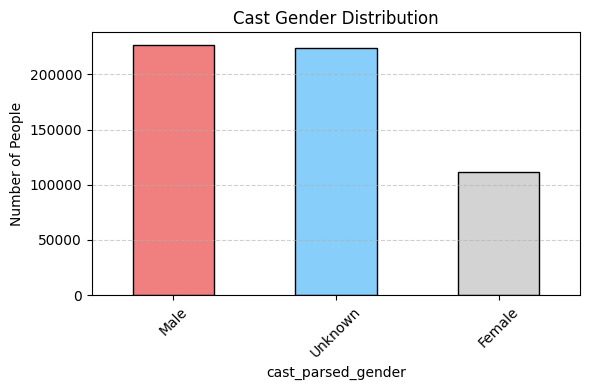


=== Crew Gender Distribution ===


,count,percent
crew_parsed_gender,,
Unknown,272319,58.65
Male,160872,34.65
Female,31123,6.70


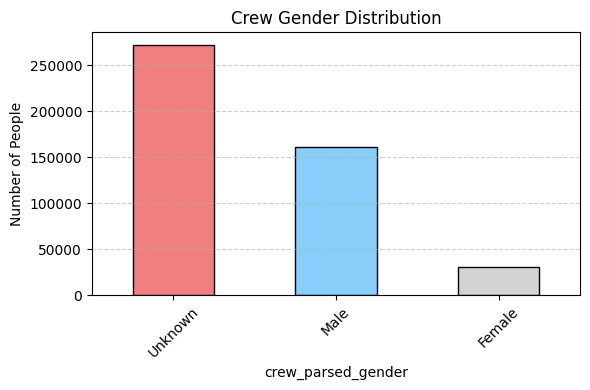

In [7]:
# =========================
# Gender Distribution for Cast and Crew
# =========================

import pandas as pd

# Gender map from TMDB documentation
gender_map = {
    0: "Unknown",
    1: "Female",
    2: "Male",
    3: "Other"
}

def explode_people(df, col):
    """Explode parsed list column (cast_parsed or crew_parsed) into long form DataFrame."""
    if col not in df.columns:
        return pd.DataFrame()
    exploded = df[[col]].explode(col, ignore_index=True)
    exploded = exploded[exploded[col].notna()]
    normalized = pd.json_normalize(exploded[col])
    normalized.columns = [f"{col}_" + c for c in normalized.columns]
    return normalized

# --- Cast gender distribution ---
if "cast_parsed" in df.columns:
    cast_long = explode_people(df, "cast_parsed")
    if not cast_long.empty and f"cast_parsed_gender" in cast_long.columns:
        cast_long["cast_parsed_gender"] = cast_long["cast_parsed_gender"].map(gender_map)
        cast_gender_counts = cast_long["cast_parsed_gender"].value_counts(dropna=False)
        cast_gender_df = pd.DataFrame({
            "count": cast_gender_counts,
            "percent": (cast_gender_counts / cast_gender_counts.sum() * 100).round(2)
        })
        print("=== Cast Gender Distribution ===")
        display(cast_gender_df)

        # Visualization
        plt.figure(figsize=(6, 4))
        cast_gender_counts.plot(kind="bar", color=["#f08080", "#87cefa", "#d3d3d3", "#dda0dd"], edgecolor="black")
        plt.title("Cast Gender Distribution")
        plt.ylabel("Number of People")
        plt.xticks(rotation=45)
        plt.grid(axis="y", linestyle="--", alpha=0.6)
        plt.tight_layout()
        plt.show()
    else:
        print("No valid gender field found for cast.")
else:
    print("No cast_parsed column found.")

# --- Crew gender distribution ---
if "crew_parsed" in df.columns:
    crew_long = explode_people(df, "crew_parsed")
    if not crew_long.empty and f"crew_parsed_gender" in crew_long.columns:
        crew_long["crew_parsed_gender"] = crew_long["crew_parsed_gender"].map(gender_map)
        crew_gender_counts = crew_long["crew_parsed_gender"].value_counts(dropna=False)
        crew_gender_df = pd.DataFrame({
            "count": crew_gender_counts,
            "percent": (crew_gender_counts / crew_gender_counts.sum() * 100).round(2)
        })
        print("\n=== Crew Gender Distribution ===")
        display(crew_gender_df)

        # Visualization
        plt.figure(figsize=(6, 4))
        crew_gender_counts.plot(kind="bar", color=["#f08080", "#87cefa", "#d3d3d3", "#dda0dd"], edgecolor="black")
        plt.title("Crew Gender Distribution")
        plt.ylabel("Number of People")
        plt.xticks(rotation=45)
        plt.grid(axis="y", linestyle="--", alpha=0.6)
        plt.tight_layout()
        plt.show()
    else:
        print("No valid gender field found for crew.")
else:
    print("No crew_parsed column found.")
